# Thursday talk

## OCloC Python Package - Reykjanes example

In order to detect and correct timing errors using ambient noise seismic inteferometry, we developed an algorithm that follows the processing sheme shown in figure . The functional workflow comprises five main processing steps: Interferometric response retrieval, data filtering, time-symmetry shift measurement, time-symmetry verification, construction of the linear system of equations, and results refinement and verification. 

## Loading the interferometric responses

In [1]:
import sys
import os
import pandas as pd
# Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ocloc import ProcessingParameters, ClockDrift

In [2]:
# Parameters for locating the files where the correlation files.
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"

# Station info is a file with the stations' metadata
station_file = '/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info'

params2 = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 30, # Signal-to-noise ratio threshold
                 noise_st = 240, # start of the noise window.
                 dt_err = 0.004, # Sampling interval needs to be multiple of this value.
                 resp_details = False)

cd = ClockDrift(station_file, path2data_dir, 
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params2])#, params3])

No correlation file found for station:O26


## IMAGE's seismic network in Reykjanes

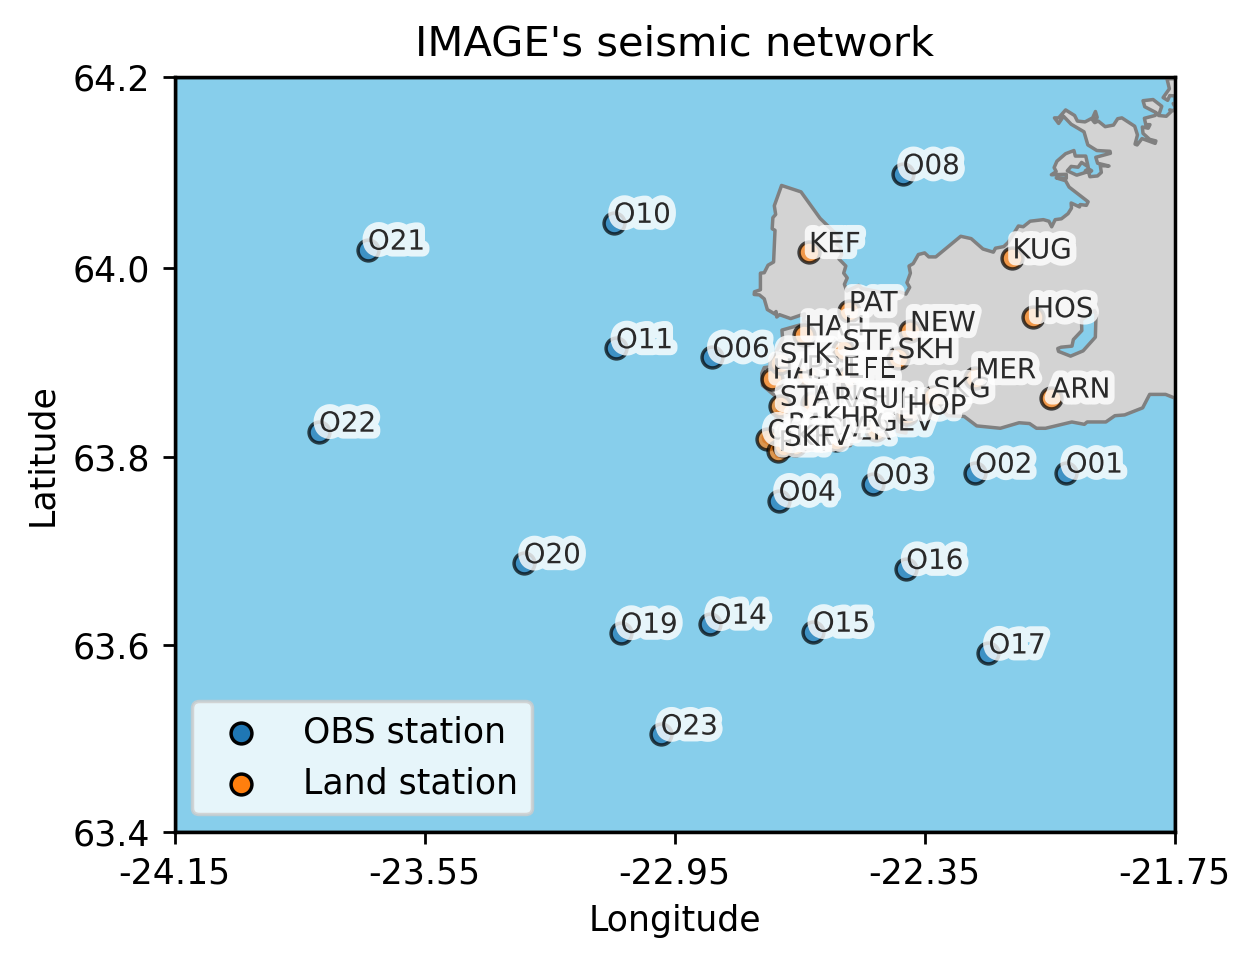

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patheffects as pe
import numpy as np
# Create the figure using Basemap.
fig = plt.figure(dpi=250)
llcrnrlon = -24.15
urcrnrlon = -21.75
llcrnrlat = 63.4
urcrnrlat = 64.2
map = Basemap(llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
              urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat,
              epsg=3857, resolution='h')
for station in cd.stations:
    plt.annotate(station.code, map(station.longitude, station.latitude),
                 zorder=9999, alpha=0.8, path_effects=[pe.withStroke(linewidth=4,
                 foreground="white")], fontsize=8)

    x, y = map(station.longitude, station.latitude)
    # Add a color depending wether the staton needs corection or not
    # In these data-set file the column "needs correction" is True for OBS, so
    # we use this attribute to select the color.
    color = 'C0' if station.needs_correction else 'C1'
    map.scatter(x, y, c=color, zorder=999,
                edgecolor='k', alpha=0.7)
for i in [1]:
    # We add the legend.
    map.scatter([],[], label='OBS station', color='C0', edgecolor='k')
    map.scatter([],[], label='Land station', color='C1', edgecolor='k')
    plt.legend(loc=3)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title("IMAGE's seismic network")

    # Add the labels
    n_ticks = 5

    x, y = map(np.linspace(llcrnrlon, urcrnrlon, n_ticks),
               np.linspace(llcrnrlat, urcrnrlat, n_ticks)
               )
    plt.xticks(x, np.linspace(llcrnrlon, urcrnrlon, n_ticks))
    plt.yticks(y, np.linspace(llcrnrlat, urcrnrlat, n_ticks))
    map.drawmapboundary(fill_color='skyblue')
    map.fillcontinents(color='lightgray')
    map.drawcoastlines(color='grey')
    plt.show()

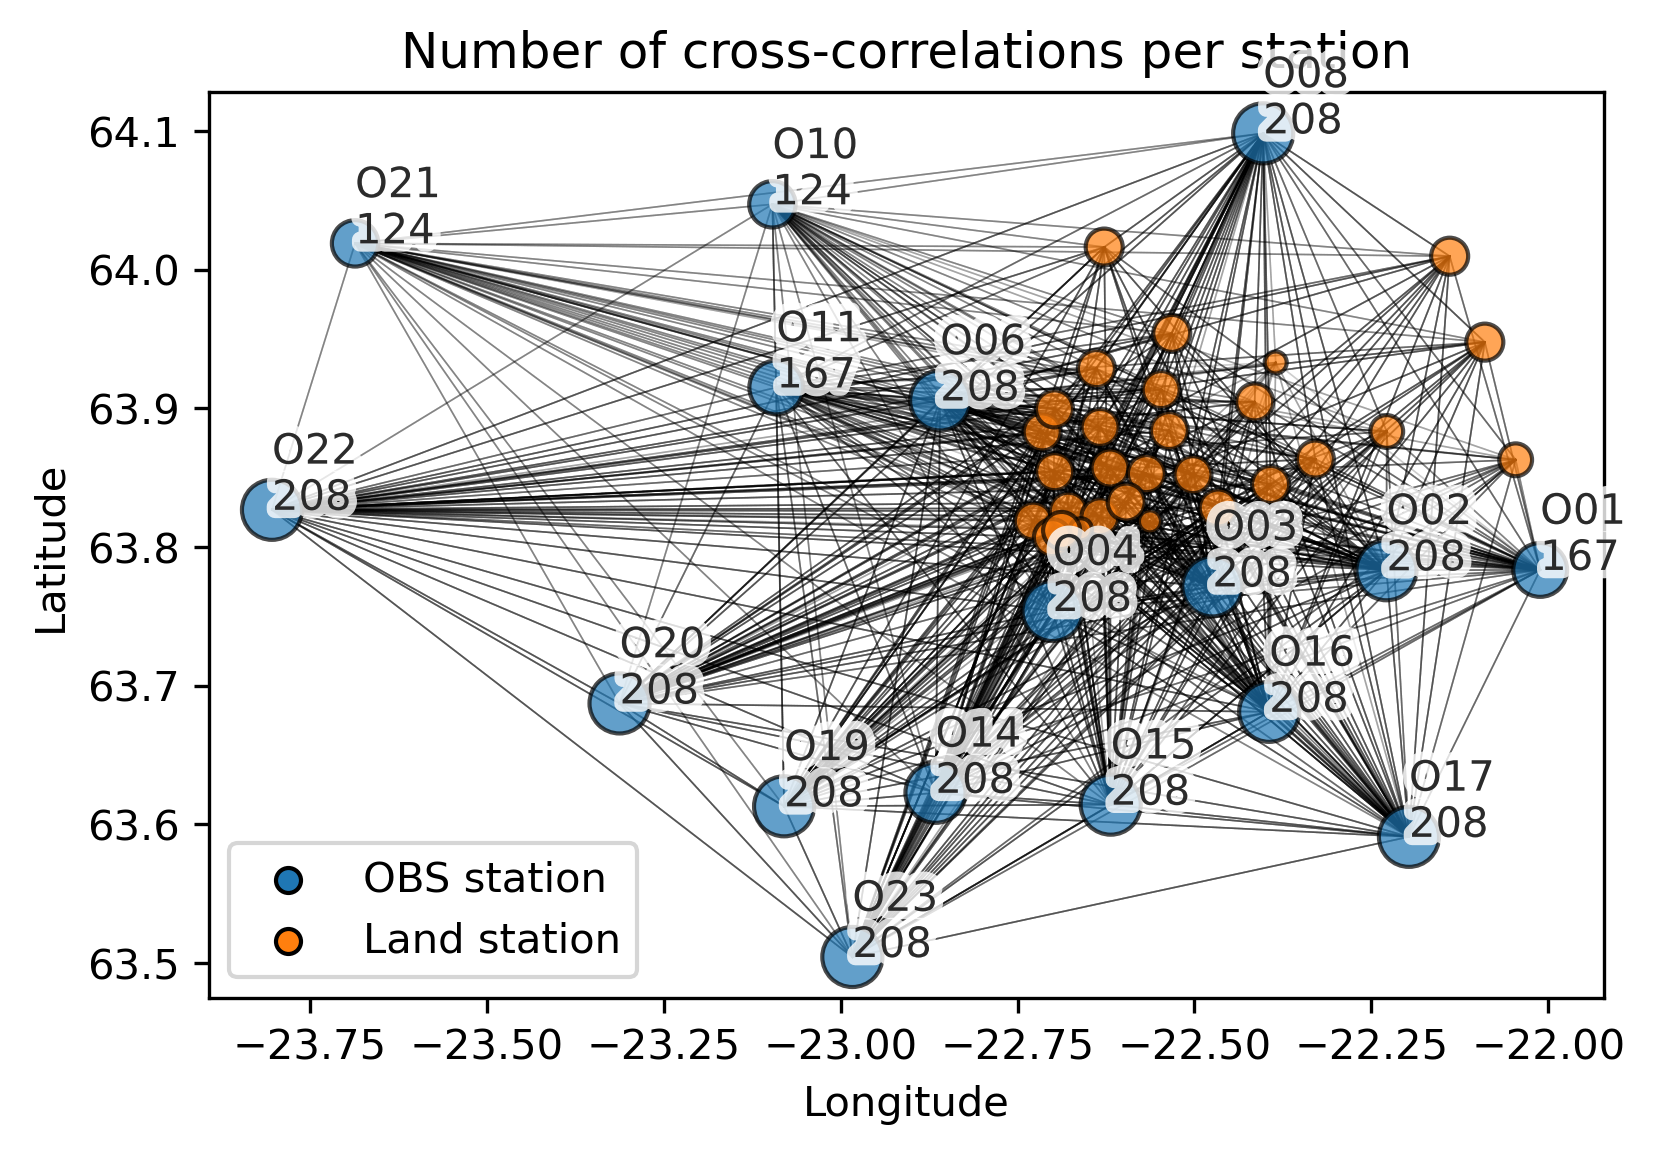

In [4]:
cd.plot_inventory_correlations()

## Plotting the crosscorrelations

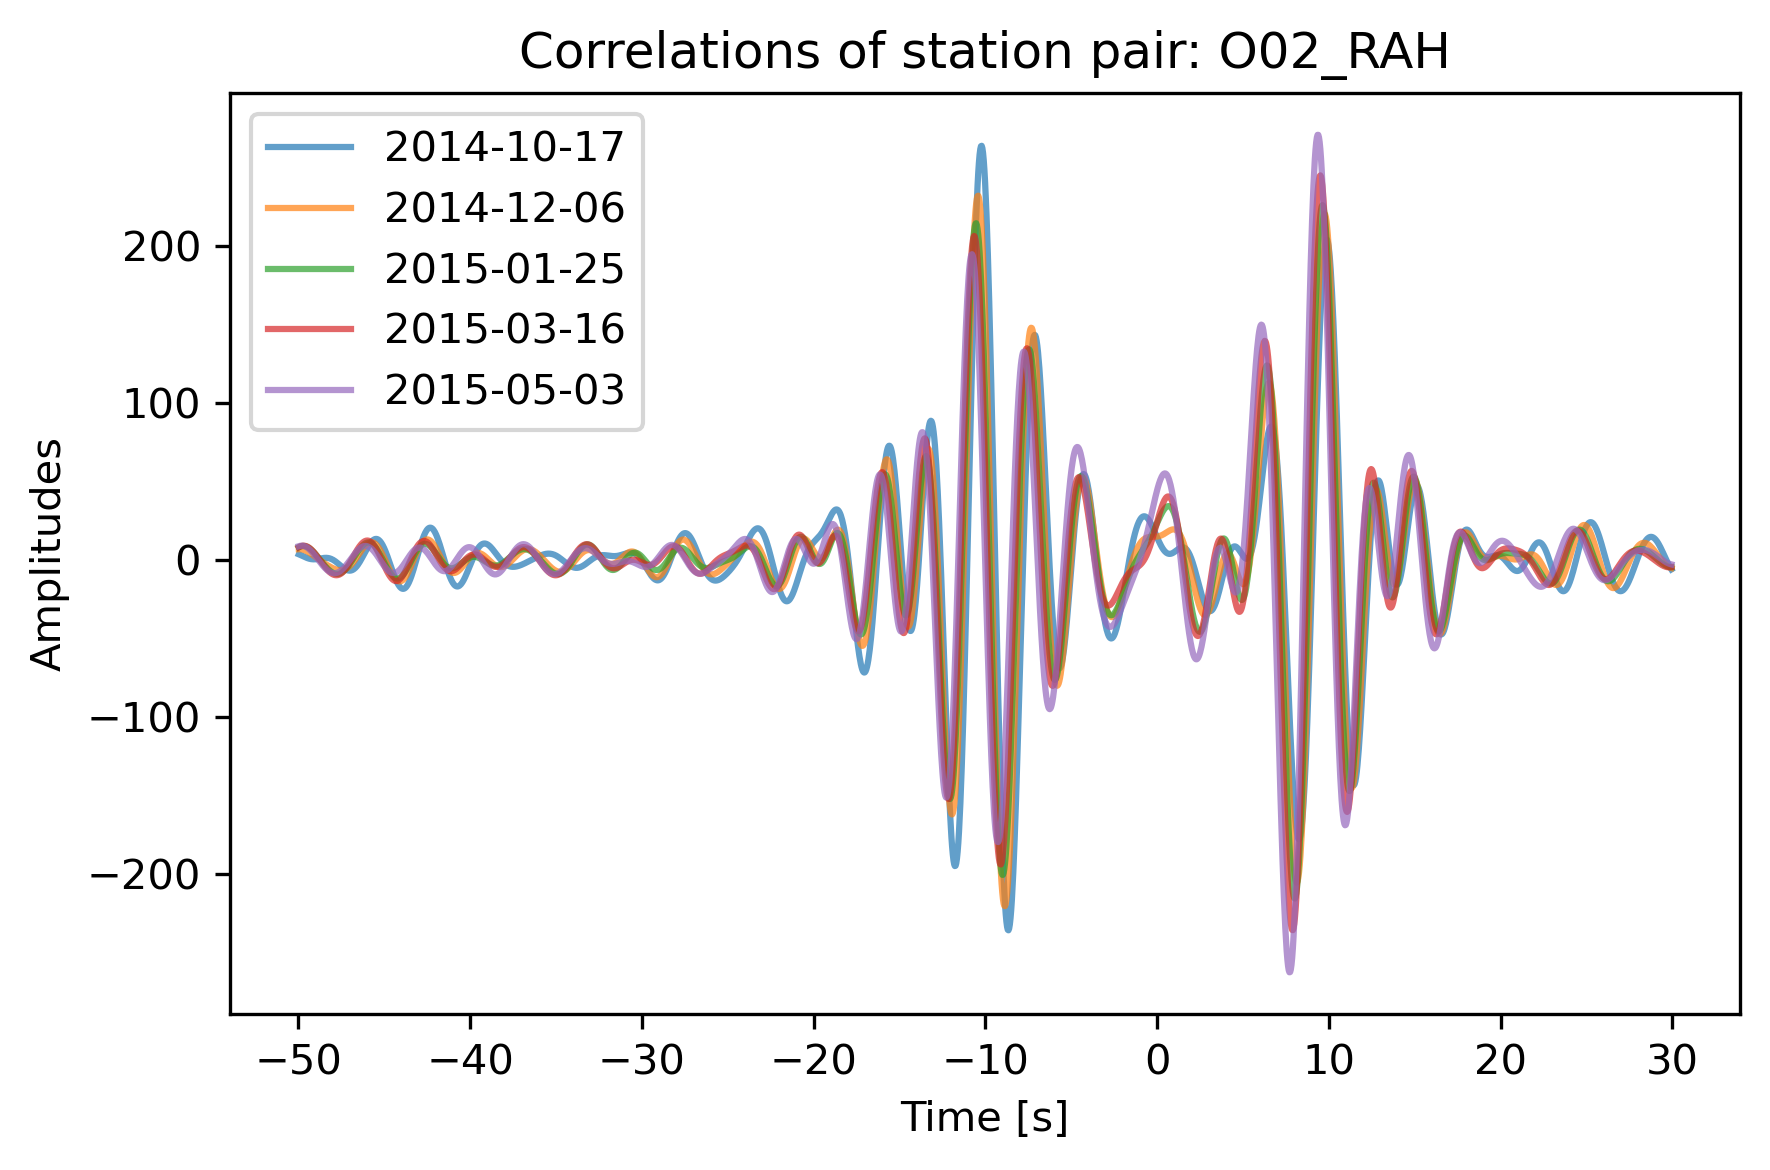

In [5]:
cd.plot_correlations_of_stationpair("O02", "RAH")

## Correlations of O20 (station with strongest clock drift)

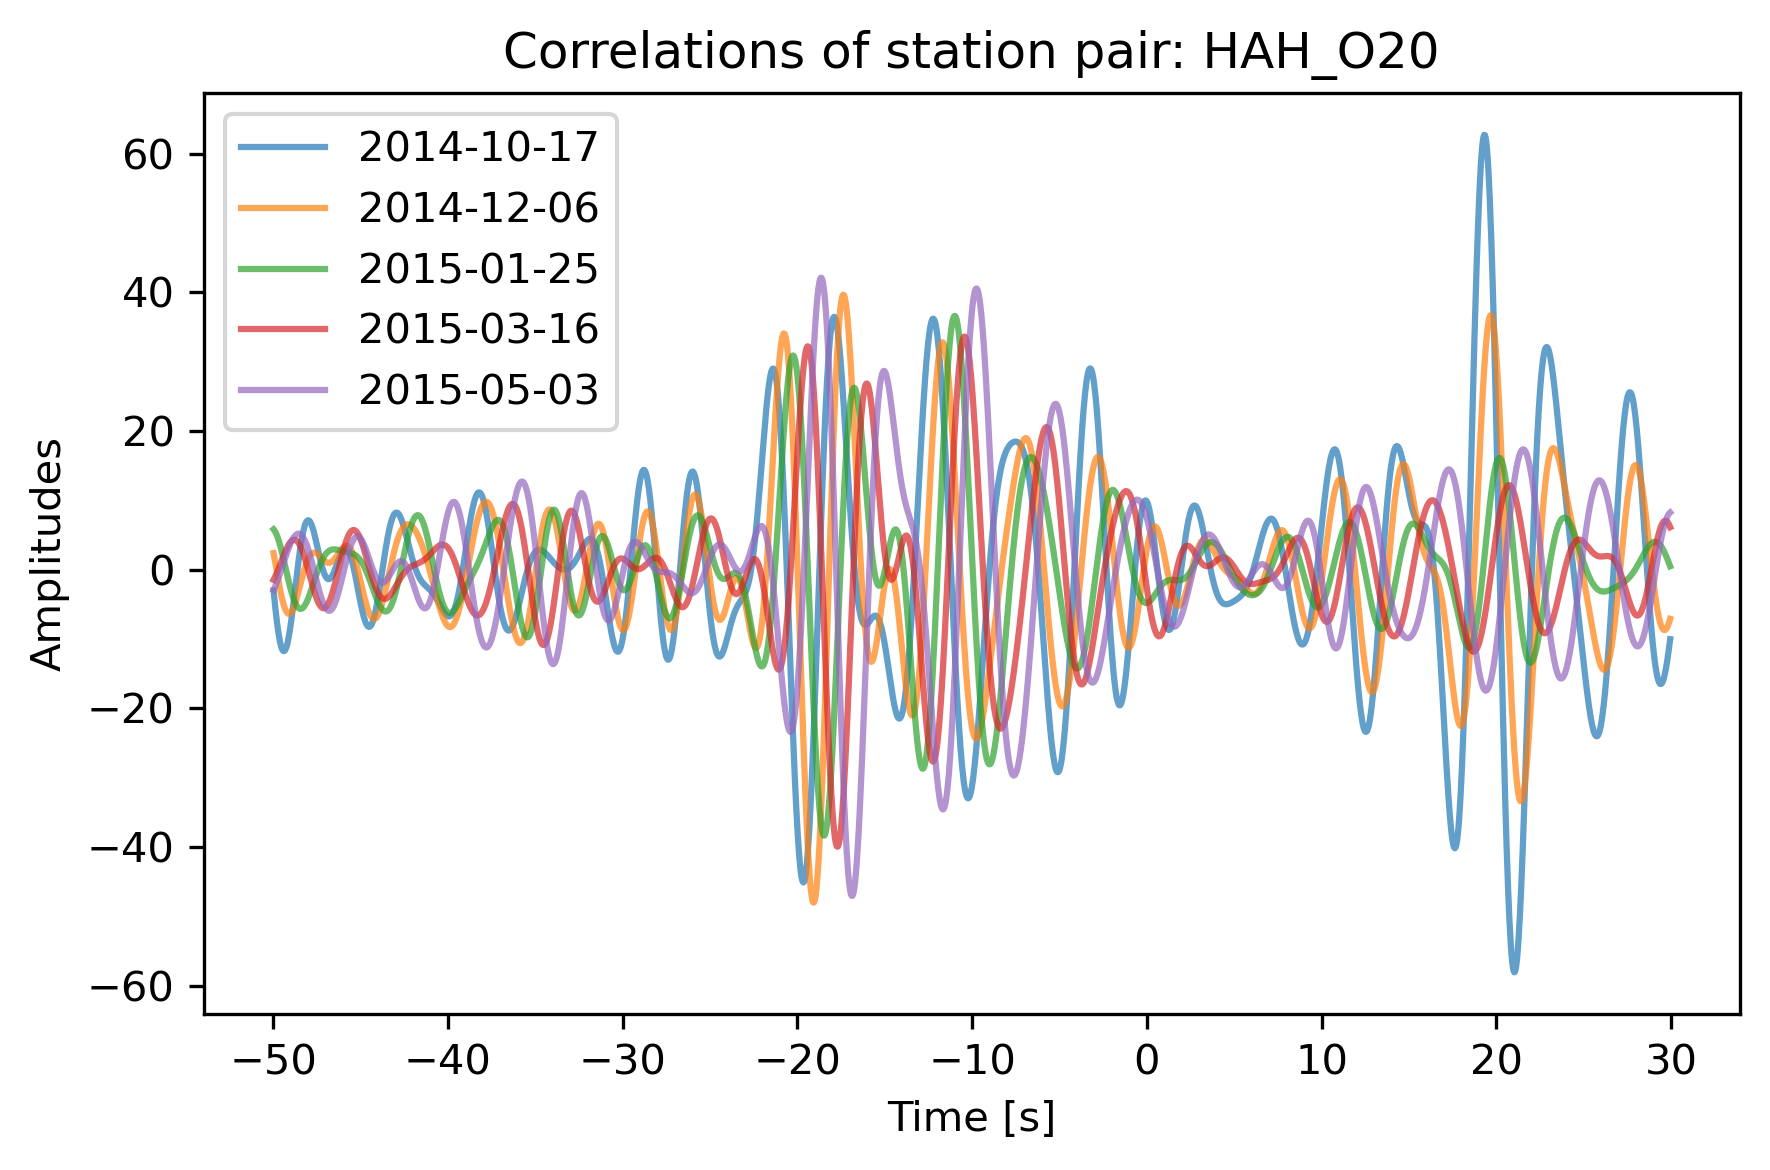

In [6]:
cd.plot_correlations_of_stationpair("HAH", "O20")

## Clock drift Zoom in 

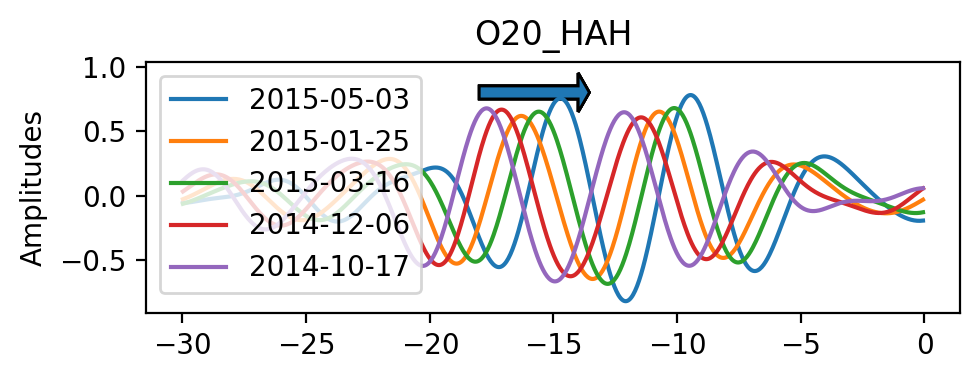

In [7]:
from ocloc import read_xcorrelations, trim_correlation_trace
st, _ = read_xcorrelations("O20", "HAH", path2data_dir)
st = st.normalize()


fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2), dpi=200)
for tr in st:
    min_t=-30
    max_t=0
    freqmin=0.15
    freqmax=0.3
    # Trim the signal to use only the part we are interested at.
    t1, data = trim_correlation_trace(tr, min_t, max_t, freqmin, freqmax)

    # index of matching element
    acausal_indixes = [idx for idx, val in enumerate(t1) if val > -22 and val < -10]
    causal_indixes = [idx for idx, val in enumerate(t1) if val > 12 and val < 25]
    ax1.plot(t1, data, label=str(tr.stats.average_date)[:10])

    plt.arrow(-18, 0.8, 4, 0, width = 0.1)

    ax1.set_title(tr.stats.station_pair)
    ax1.set_ylabel('Amplitudes')
    ax1.legend(loc=2)
    plt.tight_layout()

## Run our code and do the inversion

In [8]:
cd.calculate_aprioridt_4_allcorrelations()
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()
cd.build_matrices()
cd.solve_eq()
cd.remove_outiers(max_error=1.)
cd.calculate_dt_ins()
cd.build_matrices()
cd.solve_eq()

Calculating the apriori estimates for each stationpair
Calculating the t_app for each stationpair.
Calculating a and b for each station.
Calculating a and b for each station.


## Results

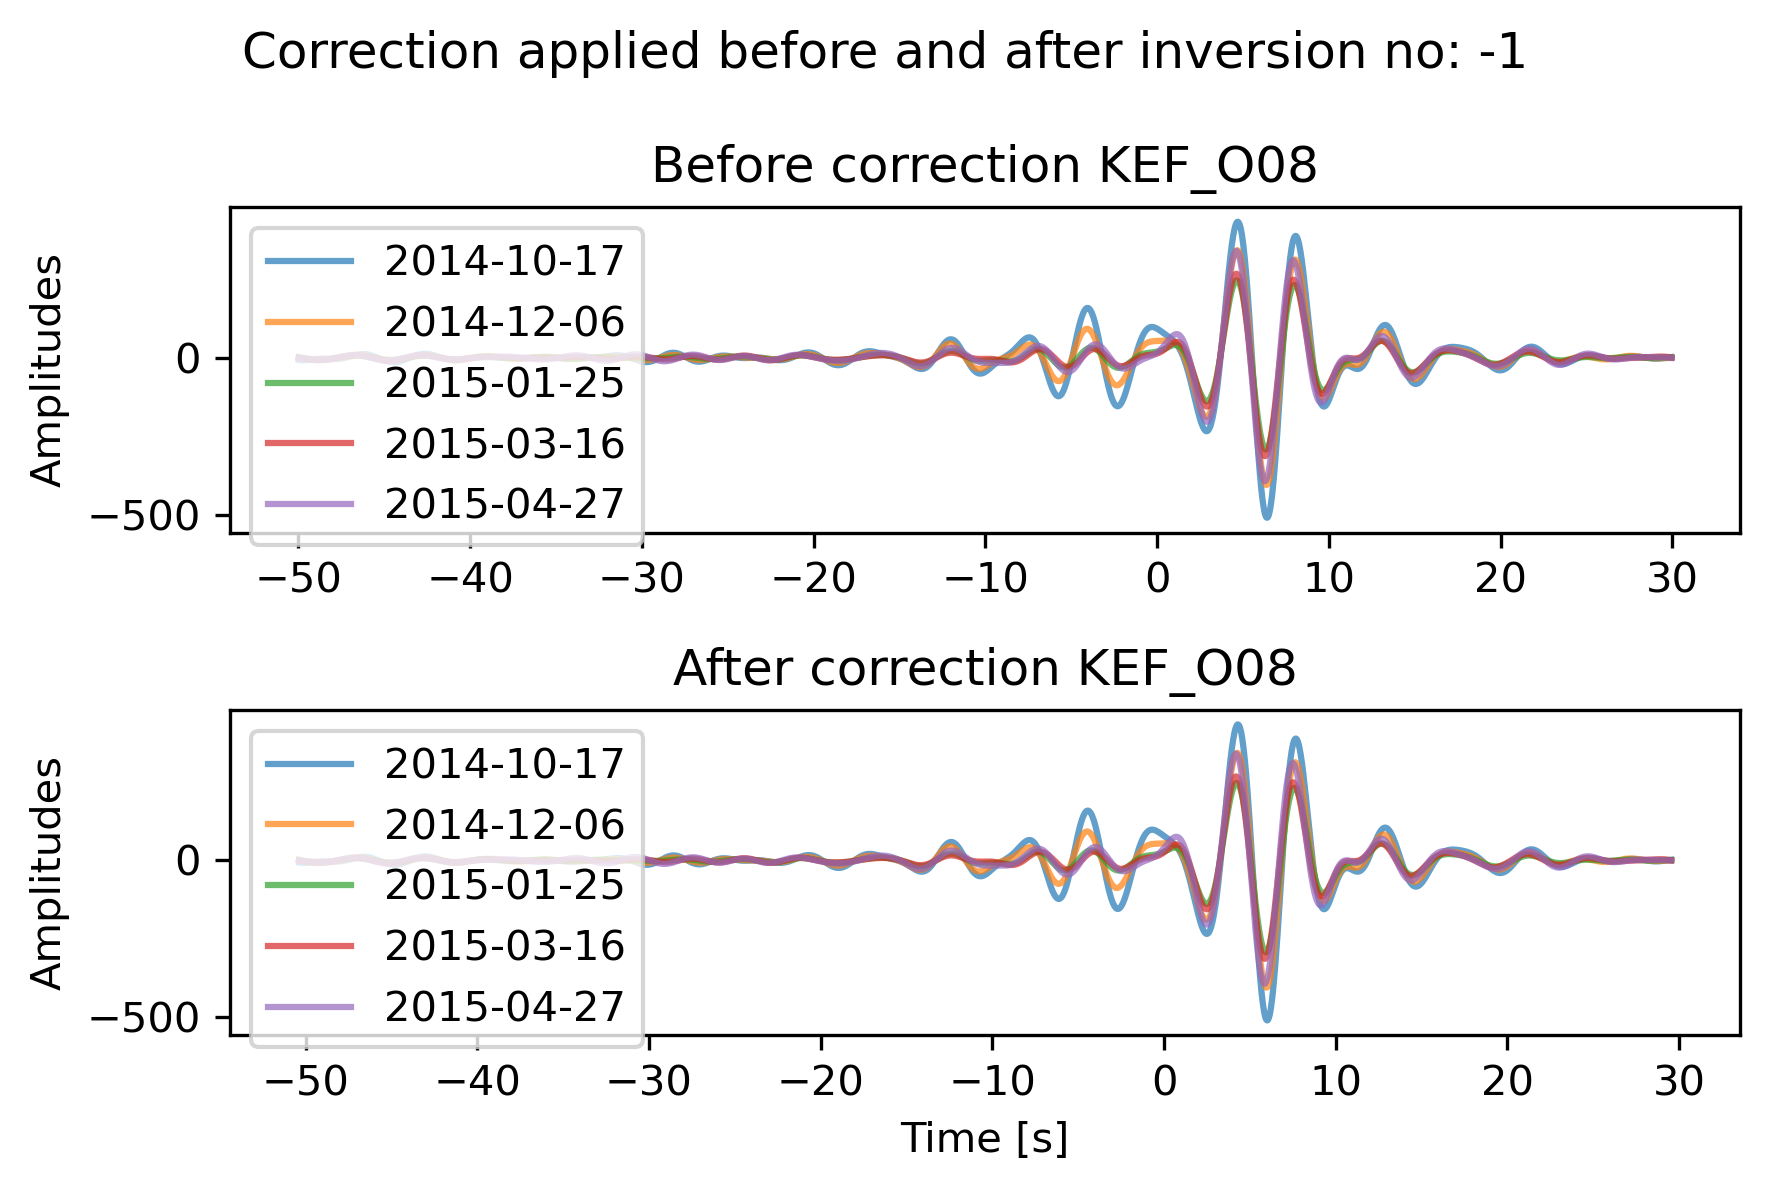

In [9]:
cd.plot_correlation_beforeNafter_correction("O08", "KEF")

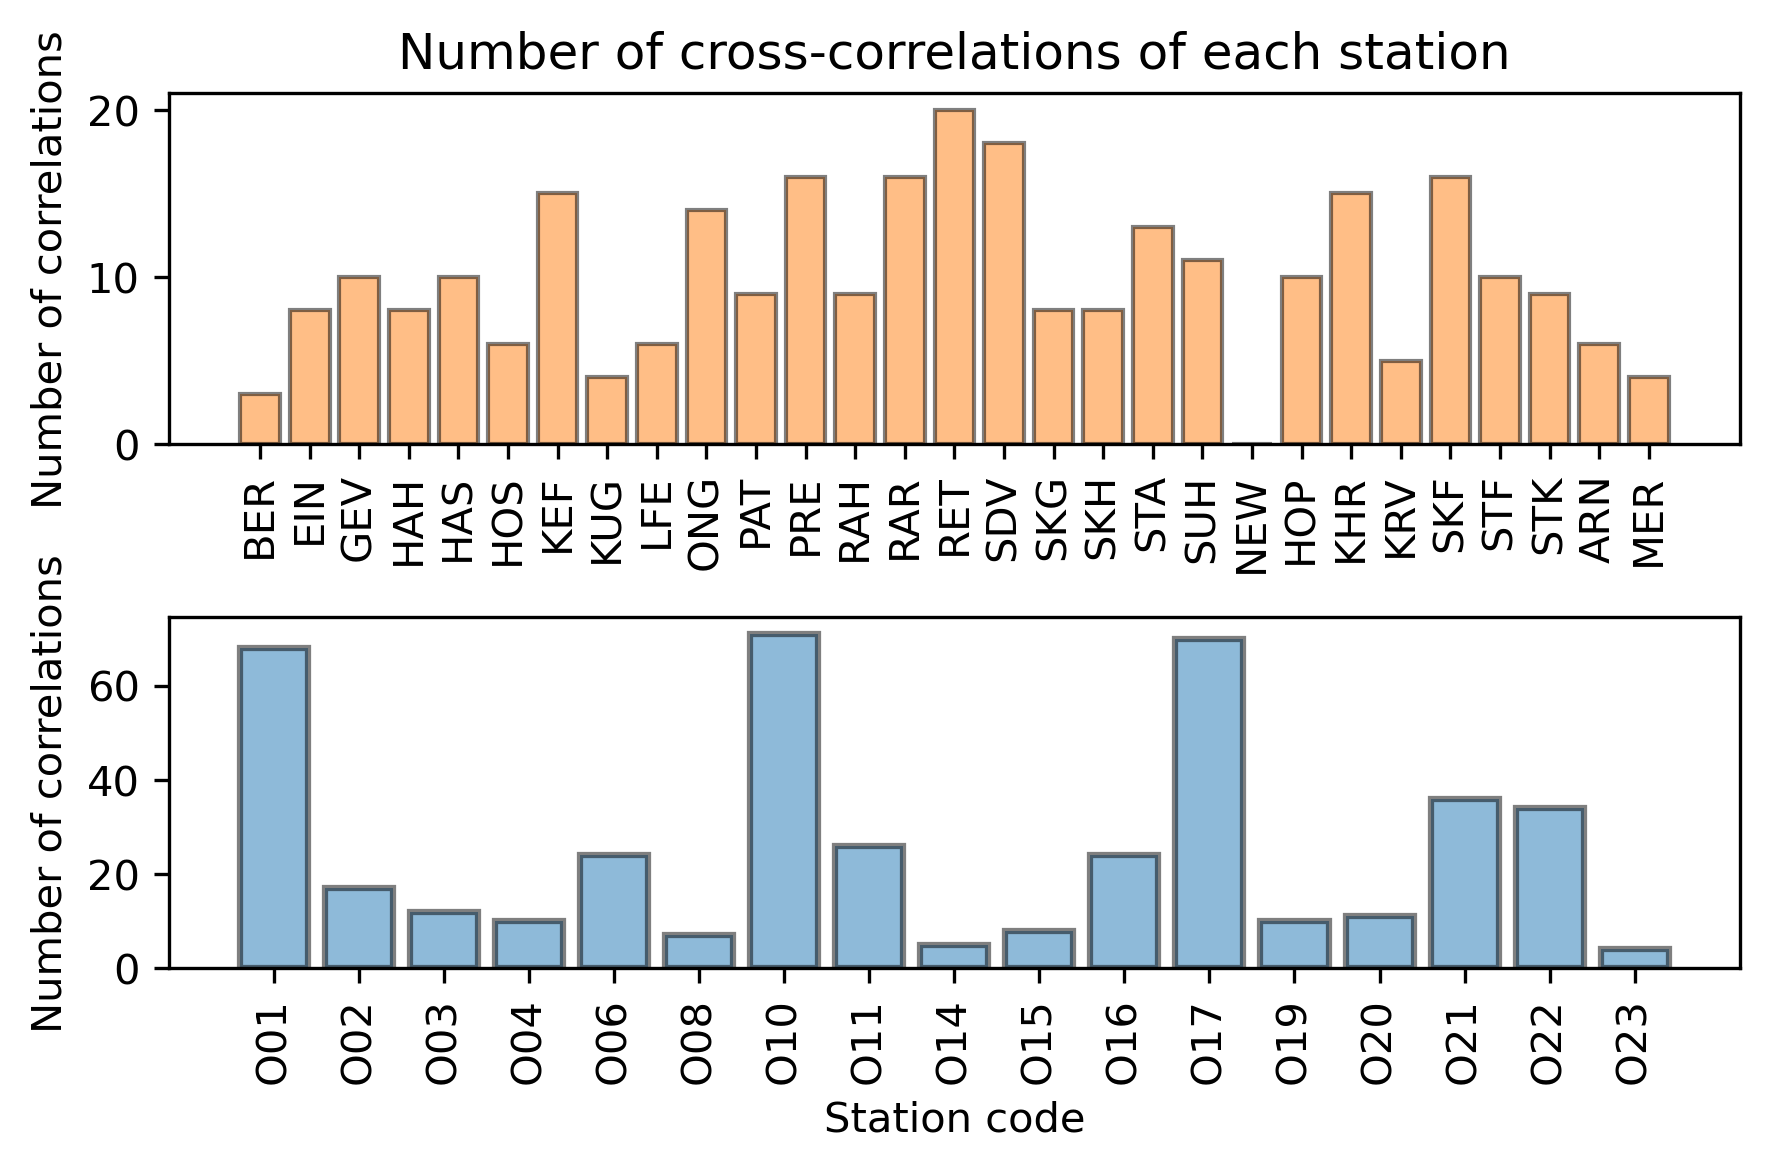

In [10]:
cd.plot_hist_no_correlations_per_station()

# Results

Having the a (clock drift rate) and b (incurred timing error at t=0) values it is possible to calculate if there is a time shift while the OBS is sinking. For calculating it is necessary to have the initial dates when the OBS started recording.

In [11]:
import pandas as pd
import obspy
import numpy as np
skew_values_file = "skew_values.csv"
path2file_skew = os.path.join(module_path, skew_values_file)
skew_df = pd.read_csv(path2file_skew, delimiter=",", header=0)

sensor_codes = skew_df["Sensor code"]
starttimes = skew_df["Start time"]
endtimes = skew_df["End time"]
ref_time = cd.reference_time
skew_measurements = skew_df["skew seconds"]


initial_shift = []
final_shift = []
corrected_stations = []
included_skews = []
clock_drift_per_day = []
for station, starttime, endtime, skew in zip(sensor_codes, starttimes,
                                       endtimes, skew_measurements):
    if station in cd.station_names:
        a = float(cd.solution["a ("+ station + ")"])
        b = float(cd.solution["b ("+ station + ")"])
        dt_start = (obspy.UTCDateTime(starttime) - ref_time)/86400
        dt_ins_start = a*(dt_start) + b
        initial_shift.append(dt_ins_start)
        
        try:
            dt_end = (obspy.UTCDateTime(endtime) - ref_time)/86400
            dt_ins_end = a*(dt_end) + b
        except:
            dt_ins_end = "Recovery time not provided"
        final_shift.append(dt_ins_end)
        corrected_stations.append(station)
        included_skews.append(skew)
        clock_drift_per_day.append(a)

final_results = pd.DataFrame(list(zip(corrected_stations, initial_shift, 
                                      final_shift, included_skews, clock_drift_per_day)),
                             columns = ["Sensor code", "Incurred timing error at t=0 [s]",
                                       "Timing error at the time of recovery [s]",
                                        "Skew [s]", 
                                        "Clock drift [s/day]"])
display(final_results)

,Sensor code,Incurred timing error at t=0 [s],Timing error at the time of recovery [s],Skew [s],Clock drift [s/day]
0,O01,-0.308156,-1.065075,2.023125,-0.002051
1,O02,-0.105317,-1.105555,1.790906,-0.003018
2,O03,-0.123568,-0.495969,1.137506,-0.001009
3,O04,-0.199972,-0.958726,1.774437,-0.002056
4,O06,-0.147203,-0.349957,1.129468,-0.000543
5,O08,-0.374483,-0.439224,1.099625,-0.000168
6,O10,-0.229556,-1.344242,1.813093,-0.002966
7,O11,-0.347732,-1.130317,1.469656,-0.002089
8,O14,-0.205662,-0.238363,1.268156,-0.000087
9,O15,-0.373404,-1.806207,2.669093,-0.003842


# Inversion strategies tested with Bootstrapping

We now compare the results from a weighted least squares inversion with the regular least squares inverison.

Bootstrapping is a kind of resampling. The idea is that we treat the sample as if it were the entire population, and simulate the sampling process by choosing random rows with replacement. DataFrame provides a method called sample we can use to select a random sample of the rows (Downey, 2020).

In [12]:
# Station info is a file with the stations' metadata
station_file = '/Users/localadmin/Dropbox/GitHub/ocloc/tutorials/station_info_bootstrapping'

cd = ClockDrift(station_file, path2data_dir,
                  reference_time = '2014-08-21T00:00:00.000000Z',
                  list_of_processing_parameters=[params2])
cd.calculate_aprioridt_4_allcorrelations()
cd.calculate_dt_ins()
cd.calculate_tapp_4_allcorrelations()
cd.build_matrices()
cd.solve_eq()
cd.remove_outiers(max_error=1.)
cd.calculate_dt_ins()
cd.build_matrices()
cd.solve_eq()

Calculating the apriori estimates for each stationpair
Calculating the t_app for each stationpair.
Calculating a and b for each station.
Calculating a and b for each station.


for station in cd.stations:
    cd.plot_correlation_beforeNafter_correction(station.code, "KEF")

In [15]:
from ocloc import suppress_stdout
from statistics import mean
average_dates = [c.average_date for c in cd.correlations]
mean_a = []
mean_b = []
with suppress_stdout():
    for i in range(800):
        bootstrapped_cd = cd.copy()
        correlations_with_tapp = []
        for c in bootstrapped_cd.correlations:
            if not np.isnan(c.t_app[-1]):
                correlations_with_tapp.append(c)
        index_list = np.random.choice(range(len(correlations_with_tapp)),
                                      replace=True,
                                      size=len(correlations_with_tapp))

        res_list = [correlations_with_tapp[i] for i in index_list]
        bootstrapped_cd.correlations = res_list
        bootstrapped_cd.filter_stations(min_number_of_total_correlations=5,
                                        min_number_correlation_periods=2, 
                                        min_number_of_stationconnections=2,
                                        days_apart=(max(average_dates) - min(average_dates)) / (5 * 86400))
        bootstrapped_cd.calculate_dt_ins()
        bootstrapped_cd.build_matrices()
        bootstrapped_cd.solve_eq(method='lstsq')

        a_vals = []
        b_vals = []
        for station in bootstrapped_cd.stations:
            if station.needs_correction:
                a_vals.append(station.a[-1])
                b_vals.append(station.b[-1])
        mean_a.append(mean(a_vals))
        mean_b.append(mean(b_vals))

# Bootstrapping using regular least-squares

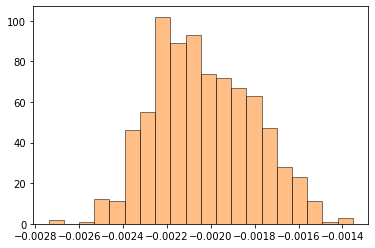

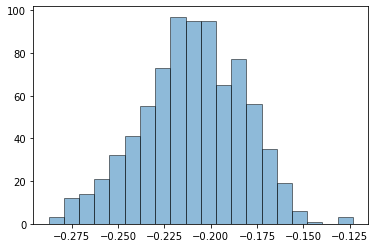

In [16]:
import matplotlib.pyplot as plt

plt.hist(mean_a, bins = 20,
        alpha=0.5,
        facecolor="C1",
        edgecolor="black",
        linewidth=1
        )
plt.show()

plt.hist(mean_b, bins = 20,
        alpha=0.5,
        facecolor="C0",
        edgecolor="black",
        linewidth=1
        )
plt.show()

In [17]:
from statistics import mean
average_dates = [c.average_date for c in cd.correlations]
mean_a = []
mean_b = []

with suppress_stdout():
    for i in range(800):
        bootstrapped_cd = cd.copy()
        correlations_with_tapp = []
        for c in bootstrapped_cd.correlations:
            if not np.isnan(c.t_app[-1]):
                correlations_with_tapp.append(c)
        index_list = np.random.choice(range(len(correlations_with_tapp)),
                                      replace=True,
                                      size=len(correlations_with_tapp))

        res_list = [correlations_with_tapp[i] for i in index_list]
        bootstrapped_cd.correlations = res_list
        bootstrapped_cd.filter_stations(min_number_of_total_correlations=5,
                                        min_number_correlation_periods=2, 
                                        min_number_of_stationconnections=2,
                                        days_apart=(max(average_dates) - min(average_dates)) / (5 * 86400))
        bootstrapped_cd.calculate_dt_ins()
        bootstrapped_cd.build_matrices()
        bootstrapped_cd.solve_eq(method='weighted_lstsq')

        a_vals = []
        b_vals = []
        for station in bootstrapped_cd.stations:
            if station.needs_correction:
                a_vals.append(station.a[-1])
                b_vals.append(station.b[-1])
        mean_a.append(mean(a_vals))
        mean_b.append(mean(b_vals))

## Bootstrapping using weighted-least squares 

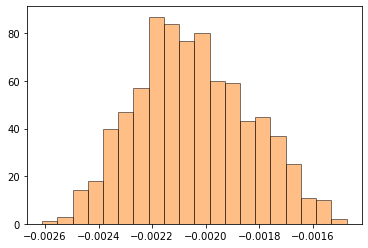

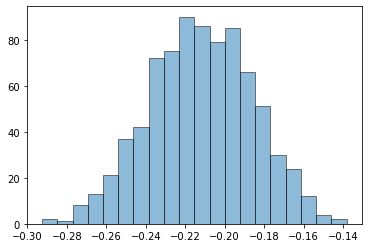

In [18]:
import matplotlib.pyplot as plt

plt.hist(mean_a, bins = 20,
        alpha=0.5,
        facecolor="C1",
        edgecolor="black",
        linewidth=1
        )
plt.show()

plt.hist(mean_b, bins = 20,
        alpha=0.5,
        facecolor="C0",
        edgecolor="black",
        linewidth=1
        )
plt.show()